# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [1]:
!pip install pytorch_lightning &> /dev/null


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# cd '/content/gdrive/MyDrive/Project2_YOLO/' 

/content/gdrive/.shortcut-targets-by-id/1Xg5KBv6SPSFcw_zBWFNcnvd15YA0LAHc/Project2_YOLO


In [4]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')

In [5]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
import math
def process_labels(raw_labels):
    labels = []
    for raw_label in raw_labels:
      processed_label = [[[0 for k in range(8)] for j in range(8)] for i in range(8)]
      for box in raw_label:
        box_class = int(box[0])
        box_class_onehot = [0, 0, 0]
        box_class_onehot[box_class] = 1
        box_center = [(box[1] + box[3]) / 2, (box[2] + box[4]) / 2]
        
        box_width, box_height = (box[3] - box[1]) / 128, (box[4] - box[2]) / 128
        grid_cell = [math.floor(box_center[0] / 16), math.floor(box_center[1] / 16)]
        box_center = np.array(box_center)
        box_center = (box_center / 16) - (box_center // 16)
        grid_cell_channels = [1, box_center[0], box_center[1], box_width, box_height] + box_class_onehot
        
        for i in range(8):
          processed_label[i][grid_cell[0]][grid_cell[1]] = grid_cell_channels[i]
   

      labels.append(np.array(processed_label))  

    return np.array(labels)

In [6]:
labels = process_labels(raw_labels)
print('labels.shape: ', labels.shape)

labels.shape:  (9900, 8, 8, 8)


In [7]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    raw_labels = []
    for label in labels:
      raw_label = []
      # print("label.shape: ", label.shape)
      for i in range(label.shape[1]):
        for j in range(label.shape[2]):
          if label[0][i][j]:
            # print(label[5:8, i, j])
            # print(np.argmax(label[5:8, i, j]))
            # box_class = np.argmax(label[5:8, i, j]).item()
            box_class = np.argmax(label[5:8, i, j])
            # 1 - x_centre, 2 - y_centre, 3 - width, 4 - height
            left_corner = [(label[1][i][j]*16+i*16) - (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) - (label[4][i][j]*128 / 2)]
            right_corner = [(label[1][i][j]*16+i*16) + (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) + (label[4][i][j]*128 / 2)]
            raw_label_box = [box_class] + left_corner + right_corner

            raw_label.append(raw_label_box)
      
      raw_labels.append(np.array(raw_label))

    return np.squeeze(np.array(raw_labels))

In [8]:
def get_iou(output, target):
    output_box_x1 = output[:, 1, :, :] - 8*output[:, 3, :, :] / 2
    output_box_y1 = output[:, 2, :, :] - 8*output[:, 4, :, :] / 2
    output_box_x2 = output[:, 1, :, :] + 8*output[:, 3, :, :] / 2
    output_box_y2 = output[:, 2, :, :] + 8*output[:, 4, :, :] / 2
    target_box_x1 = target[:, 1, :, :] - 8*target[:, 3, :, :] / 2
    target_box_y1 = target[:, 2, :, :] - 8*target[:, 4, :, :] / 2
    target_box_x2 = target[:, 1, :, :] + 8*target[:, 3, :, :] / 2
    target_box_y2 = target[:, 2, :, :] + 8*target[:, 4, :, :] / 2

    x1 = torch.max(output_box_x1, target_box_x1)
    y1 = torch.max(output_box_y1, target_box_y1)
    x2 = torch.min(output_box_x2, target_box_x2)
    y2 = torch.min(output_box_y2, target_box_y2)

    # print(x1[0])
    # print(x2[0])
    # print(y1[0])
    # print(y2[0])

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    # output_box_area = abs((output_box_x2 - output_box_x1) * (output_box_y2 - output_box_y1))
    # target_box_area = abs((target_box_x2 - target_box_x1) * (target_box_y2 - target_box_y1))
    output_box_area = target[:, 3, :, :] * target[:, 4, :, :] * 8**2
    target_box_area = output[:, 3, :, :] * output[:, 4, :, :] * 8**2

    return intersection / (output_box_area + target_box_area - intersection + 1e-6)

In [9]:
def yolo_loss(output, target):
    lambda_coord = 5
    lamda_no_obj = 0.5
    B = 1
    IOU = get_iou(output, target)
    
    output_objectness = output[:, 0, :, :]
    output_x_centers = output[:, 1, :, :]
    output_y_centers = output[:, 2, :, :]
    output_widths = output[:, 3, :, :]
    output_heights = output[:, 4, :, :]
    output_class_pred = output[:, 5:, :, :]

    target_objectness = target[:, 0, :, :]
    target_x_centers = target[:, 1, :, :]
    target_y_centers = target[:, 2, :, :]
    target_widths = target[:, 3, :, :]
    target_heights = target[:, 4, :, :]
    target_class_pred = target[:, 5:, :, :]

    target_no_objectness = 1 - target_objectness
    # print(output_x_centers[0])
    
    # print(output_y_centers[0])
    first_summation = torch.sum(target_objectness * (torch.square(output_x_centers - target_x_centers) + \
                                                  torch.square(output_y_centers - target_y_centers)))


    # print("output_widths: ", output_widths)
    # print("output_heights: ", output_heights)
    
    # second_summation = torch.sum(target_objectness \
    #                               * ( \
    #                                   torch.square(torch.sqrt(target_widths) - output_widths.sign() * torch.sqrt(torch.abs(output_widths))) \
    #                                   + torch.square(torch.sqrt(target_heights) - output_heights.sign() * torch.sqrt(torch.abs(output_heights)))\
    #                                 ) \
    #                             )

    second_summation = torch.sum(target_objectness \
                                  * ( \
                                      torch.square(torch.sqrt(target_widths) - torch.sqrt(output_widths)) \
                                      + torch.square(torch.sqrt(target_heights) - torch.sqrt(output_heights))\
                                    ) \
                                )
    
    third_summation = torch.sum(target_objectness * torch.square(target_objectness*IOU - output_objectness))

    fourth_summation = torch.sum(target_no_objectness * torch.square(target_objectness*IOU - output_objectness))
    
    fifth_summation = torch.sum(target_objectness * torch.sum(torch.square(output_class_pred - target_class_pred), axis = 1))
    # CELoss = nn.CrossEntropyLoss()
    # fifth_summation = torch.sum(target_objectness * CELoss(), axis = 1))
    
    # print("IOU: ", IOU)
    # print("first_summation: ", first_summation)
    # print("second_summation: ", second_summation)
    # print("third_summation: ", third_summation)
    # print("fourth_summation: ", fourth_summation)
    # print("fifth_summation: ", fifth_summation)
   
    loss = lambda_coord * first_summation + \
            lambda_coord * second_summation + \
            third_summation + \
            lamda_no_obj * fourth_summation + \
            fifth_summation

    # return loss / output.shape[0]
    return loss

In [153]:
from torch.nn.modules.pooling import MaxPool2d

train_mAP = []
val_mAP = []

class YOLO(pl.LightningModule):

    model_url = "https://drive.google.com/uc?id=13pvJRMLBZxs-jJAQfSTD-kn4RFZXjyP0&export=download&confirm=t&uuid=3ed85dde-7a19-4992-92a4-3d81c14ba74c"
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=32),
                                          nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=64),
                                          nn.ReLU())
        
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=128),
                                          nn.ReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=256),
                                          nn.ReLU())
        
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=512),
                                          nn.ReLU())
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
                                          nn.BatchNorm2d(num_features=1024),
                                          nn.ReLU())
        
        self.transposed_conv7 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU())
        
        self.transposed_conv8 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1),
                                              nn.BatchNorm2d(64),
                                              nn.ReLU())
        
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.transposed_conv7(x)
        x = self.transposed_conv8(x)
        x = self.conv9(x)
        x = self.sigmoid(x)
        return x

    def load_from_url():
      return YOLO.load_from_checkpoint(YOLO.model_url)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = yolo_loss(y_hat, y)
        self.log("Train Loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {"loss":loss, "pred":y_hat, "labels":y}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = yolo_loss(y_hat, y)
        self.log("Val Loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {"val_loss":loss, "pred":y_hat, "labels":y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_hat = self.forward(x)
    #     loss = yolo_loss(y_hat, y)
    #     self.log("Test Loss", loss)
    #     return loss
    def training_epoch_end(self, outputs):

        preds = []
        targets = []

        for d in outputs:
            preds.append(d['pred'])
            targets.append(d['labels'])
        # print(len(preds))
        # print(preds[0].shape)
            
        
        


        preds = torch.cat(preds, dim=0).detach().cpu()
        targets = torch.cat(targets, dim=0).detach().cpu()

        # NMS and Mean Average Precision
        # for i, pred in enumerate(preds):
        preds = low_confidence_suppression_(preds)
        preds = non_max_suppression_(preds)
        # preds[i]=pred
        pred_list = []
        target_list = []
        for pred in preds:
          pred_list.append(pred.unsqueeze(0))
        for target in targets:
          target_list.append(target.unsqueeze(0))


        train_mAP.append(mean_average_precision(pred_list, target_list))

        return

    def validation_epoch_end(self, outputs):

        preds = []
        targets = []

        for d in outputs:
            preds.append(d['pred'])
            targets.append(d['labels'])
        
            
        
        


        preds = torch.cat(preds, dim=0).detach().cpu()
        targets = torch.cat(targets, dim=0).detach().cpu()
        # print(preds.shape)
        # NMS and Mean Average Precision
        # for i, pred in enumerate(preds):
        preds = low_confidence_suppression_(preds)
        preds = non_max_suppression_(preds)
        # preds[i]=pred
        pred_list = []
        target_list = []
        for pred in preds:
          pred_list.append(pred.unsqueeze(0))
        for target in targets:
          target_list.append(target.unsqueeze(0))

        val_mAP.append(mean_average_precision(pred_list, target_list))

        return

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # sigmoid = nn.Sigmoid()
        # softmax = nn.Softmax()
        x, y = batch
        y_hat = self.forward(x)
        # y_hat[:, 0, :, :] = sigmoid(y_hat[:, 0, :, :])
        # y_hat[:, 5:, :, :] = softmax(y_hat[:, 5:, :, :])
        return y_hat

    def inference(self, images, labels):

        

      transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

      processed_labels = process_labels(labels)

      YoloInfereneData = YoloDataset(images, processed_labels, transform)
      YoloDataloader = YoloDataModule(YoloInfereneData, batch_size=32)

      trainer = pl.Trainer(devices=1, accelerator="cpu", max_epochs=1)
      test = trainer.predict(model=self, dataloaders=YoloDataloader)

      test_labels = []
      for i, input in enumerate(YoloDataLoader.predict_dataloader()):
        # if i == image_num:
        image_num = i
        low_label = low_confidence_suppression(test[image_num])
        test_label = non_max_suppression(low_label)
        test_labels.append(test_label)
      

      preds = [reconstruct_raw_labels_map(prediction) for prediction in test_labels]

     
      for i,p in enumerate(preds):
        if len(list(p))==0:
          preds[i]=None
          
      return np.array(preds, dtype=object)

In [149]:
def low_confidence_suppression_(labels):
    lab =[]
    # print('before', labels.shape)
    for i, label in enumerate(labels):
      label = label.unsqueeze(0)
    
      mask = label[:,0,:,:]>0.6
      label = label*mask
      labels[i] = label.squeeze(0)
    # print(labels.shape)
    return labels

def non_max_suppression_(labels):
    
    lab = []
    
    for i, label in enumerate(labels):
      thresh_iou = 0.5
      label = label.unsqueeze(0)
      # we extract coordinates for every 
      # prediction box present in P
      x1 = (label[:, 1, :, :] - 8*label[:, 3, :, :] / 2).squeeze(0).reshape(-1)
      y1 = (label[:, 2, :, :] - 8*label[:, 4, :, :] / 2).squeeze(0).reshape(-1)
      x2 = (label[:, 1, :, :] + 8*label[:, 3, :, :] / 2).squeeze(0).reshape(-1)
      y2 = (label[:, 2, :, :] + 8*label[:, 4, :, :] / 2).squeeze(0).reshape(-1)
      # x1 = label[:, 1, :, :].squeeze(0).reshape(-1)
      # y1 = label[:, 2, :, :].squeeze(0).reshape(-1)
      # x2 = label[:, 3, :, :].squeeze(0).reshape(-1)
      # y2 = label[:, 4, :, :].squeeze(0).reshape(-1)
      

      # we extract the confidence scores as well
      scores = label[:, 0, :, :].squeeze(0).reshape(-1)

      # calculate area of every block in P
      areas = (x2 - x1) * (y2 - y1)
      
      # sort the prediction boxes in P
      # according to their confidence scores
      order = scores.argsort()
      # print(order.shape)
      # print(order)

      # initialise an empty list for 
      # filtered prediction boxes
      keep = np.zeros(scores.shape)
      

      while len(order) > 0:
          
          # extract the index of the 
          # prediction with highest score
          # we call this prediction S
          idx = order[-1]

          # push S in filtered predictions list
          # print(label)
          # print(idx)
          keep[idx] += 1

          # remove S from P
          order = order[:-1]

          # sanity check
          if len(order) == 0:
              break
          
          # select coordinates of BBoxes according to 
          # the indices in order
          xx1 = torch.index_select(x1,dim = 0, index = order)
          xx2 = torch.index_select(x2,dim = 0, index = order)
          yy1 = torch.index_select(y1,dim = 0, index = order)
          yy2 = torch.index_select(y2,dim = 0, index = order)

          # find the coordinates of the intersection boxes
          xx1 = torch.max(xx1, x1[idx])
          yy1 = torch.max(yy1, y1[idx])
          xx2 = torch.min(xx2, x2[idx])
          yy2 = torch.min(yy2, y2[idx])

          # find height and width of the intersection boxes
          w = (xx2 - xx1)
          h = (yy2 - yy1)
          
          # take max with 0.0 to avoid negative w and h
          # due to non-overlapping boxes
          # print(w, h)
          for i, num in enumerate(w):
            if num<0:
              w[i]=0.0
          for i, num in enumerate(h):
            if num<0:
              h[i]=0.0


          # find the intersection area
          inter = w*h

          # find the areas of BBoxes according the indices in order
          rem_areas = torch.index_select(areas, dim = 0, index = order) 

          # find the union of every prediction T in P
          # with the prediction S
          # Note that areas[idx] represents area of S
          union = (rem_areas - inter) + areas[idx]
          
          # find the IoU of every prediction in P with S
          IoU = inter / union

          # keep the boxes with IoU less than thresh_iou
          mask = IoU < thresh_iou
          order = order[mask]
      # print(keep)
      
      label = label*keep.reshape(8,8)
      # print(label.shape)
      # print(label.squeeze(0).shape)
      
      labels[i] = label.squeeze()
    # print(labels.shape)
    return labels

In [110]:
def reconstruct_raw_labels_map_(labels, img_dim=128):
    raw_labels = []
    for label in labels:
      raw_label = []
      # print("label.shape: ", label.shape)
      for i in range(label.shape[1]):
        for j in range(label.shape[2]):
          if label[0][i][j]:
            # print(label[5:8, i, j])
            # print(np.argmax(label[5:8, i, j]))
            # box_class = np.argmax(label[5:8, i, j]).item()
            box_class = np.argmax(label[5:8, i, j])
            # 1 - x_centre, 2 - y_centre, 3 - width, 4 - height
            left_corner = ((label[1][i][j]*16+i*16) - (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) - (label[4][i][j]*128 / 2))
            right_corner = ((label[1][i][j]*16+i*16) + (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) + (label[4][i][j]*128 / 2))
            raw_label_box = (box_class, label[0][i][j]) + left_corner + right_corner

            raw_label.append(raw_label_box)
      
      raw_labels.append(raw_label)
      # if len(raw_labels)==1:
      #   return raw_label

    return raw_labels

In [111]:
def IoU_para(pred_bbox, gt_bbox):
  _, x1_pred, y1_pred, x2_pred, y2_pred = pred_bbox
  _, x1_gt, y1_gt, x2_gt, y2_gt = gt_bbox
  intersect_x_lb = max(x1_gt, x1_pred)
  intersect_x_ub = min(x2_gt, x2_pred)
  intersect_y_lb = max(y1_gt, y1_pred)
  intersect_y_ub = min(y2_gt, y2_pred)
  intersection = max(0, intersect_x_ub - intersect_x_lb) * max(0, intersect_y_ub - intersect_y_lb)
  union = (x2_pred - x1_pred) * (y2_pred - y1_pred) + (x2_gt - x1_gt) * (y2_gt - y1_gt) - intersection + 1e-6
  iou = intersection / union
  return iou

In [112]:
from collections import defaultdict

In [113]:
def precision_recall_curve(predictions, targets, target_class):
  
    true_pos = []
    false_pos = []
    conf = []
    total_gts = 0

    N = len(predictions)

    for i in range(N):
        pred_bboxes = sorted(predictions[i][target_class],reverse=True)
        num_pred_bboxes = len(pred_bboxes)
        gt_bboxes = targets[i][target_class]
        num_gt_bboxes = len(gt_bboxes)
        total_gts += num_gt_bboxes
        
        # If there are no predicted bounding boxes for the particular class in the image, continue to the next image 
        if num_pred_bboxes == 0:
            continue
        
        assigned_gt_bboxes = set()

        for j, pred_bbox in enumerate(pred_bboxes):
            conf.append(pred_bbox[0])
            # If there are no ground truths of the particular class in the image, the prediction is a false positive 
            if num_gt_bboxes == 0:
                true_pos.append(0)
                false_pos.append(1)
                continue
            
            pred_bbox_ious = []

            for k, gt_bbox in enumerate(gt_bboxes):                
                iou = IoU_para(pred_bbox, gt_bbox)
                pred_bbox_ious.append(iou)

            
            pred_bbox_ious = np.array(pred_bbox_ious)
            candidate_gt_bbox = np.argmax(pred_bbox_ious)

            if pred_bbox_ious[candidate_gt_bbox] < 0.5 or candidate_gt_bbox in assigned_gt_bboxes:
                true_pos.append(0)
                false_pos.append(1)
            else:
                true_pos.append(1)
                false_pos.append(0)
                assigned_gt_bboxes.add(candidate_gt_bbox)
    
    if total_gts == 0:
        return [], []
    
    conf = np.array(conf)
    order = np.argsort(conf)[::-1]
    true_pos = np.array(true_pos)[order]
    false_pos = np.array(false_pos)[order]
    
    cum_true_pos = true_pos.cumsum()
    cum_false_pos = false_pos.cumsum()
    
    precision =  cum_true_pos / (cum_true_pos + cum_false_pos)
    recall = cum_true_pos / total_gts
    return recall, precision

def average_precision(predictions, targets, target_class):
    recall, precision = precision_recall_curve(predictions, targets, target_class)
    precision = np.maximum.accumulate(precision[::-1])[::-1]
    # average_precision = auc(recall, precision)
    average_precision = 0
    n = len(precision)
    for i in range(1, n):
        average_precision += precision[i] * (recall[i] - recall[i - 1])

    return average_precision

def mean_average_precision(predictions, targets):
    avg_precision = []
    predictions_list =[]
    targets_list =[]
    # print(predictions[0])
    for i in range(len(predictions)):
      predictions_list.append(reconstruct_raw_labels_map_(predictions[i]))
      targets_list.append(reconstruct_raw_labels_map_(targets[i]))
    # print(predictions_list)
    
    
    predictions_dict_list= []
    targets_dict_list = []
    for i,prediction in enumerate(predictions_list):
      predictions_dict = defaultdict(list)
      for bboxs in prediction:
        for bbox in bboxs:
          # print(bbox)
          if bbox[0] == 0:
            predictions_dict['0'].append(bbox[1:])
          if bbox[0] ==1:
            predictions_dict['1'].append(bbox[1:])
          if bbox[0] == 2:
            predictions_dict['2'].append(bbox[1:])
      predictions_dict_list.append(predictions_dict)
      
    for i,target in enumerate(targets_list):
      targets_dict = defaultdict(list)
      for bboxs in target:
        for bbox in bboxs:
          if bbox[0] == 0:
            targets_dict['0'].append(bbox[1:])
          if bbox[0] ==1:
            targets_dict['1'].append(bbox[1:])
          if bbox[0] == 2:
            targets_dict['2'].append(bbox[1:])
      targets_dict_list.append(targets_dict)
    # print('nkh',np.array(predictions_dict_list[0]['0']))
    for cls in ['0', '1', '2']:
      # if len(np.array(predictions_dict[cls])) == 0:

      #   continue
      avg_precision_class = average_precision(predictions_dict_list, targets_dict_list, cls)
      avg_precision.append(avg_precision_class)
    mean_average_precision = np.mean(avg_precision)
    return round(mean_average_precision*100,2)

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

In [115]:
import matplotlib.patches as patches
chosen_image = images[8]
chosen_label = raw_labels[8]
label_processed = process_labels(raw_labels[8:9])

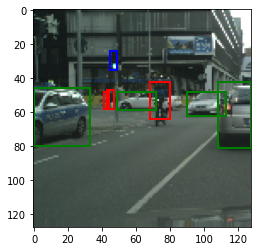

In [116]:
# Show the chosen image with ground truth bounding boxes visualized.
def bbox_to_rect(bbox, color):
    return patches.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)
fig = plt.imshow(chosen_image)
for label in chosen_label:
  if label[0] == 0:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'red'))
  if label[0] == 1:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'blue'))
  if label[0] == 2:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'green'))
  

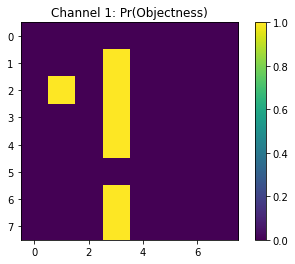

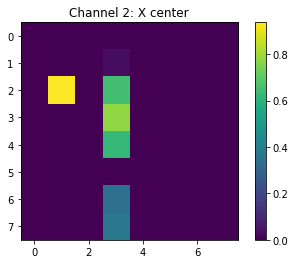

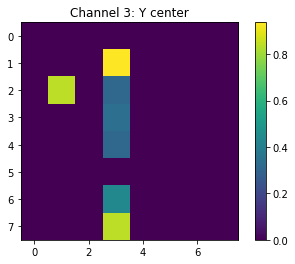

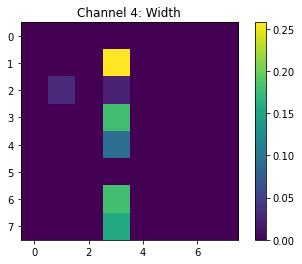

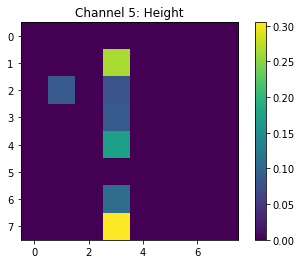

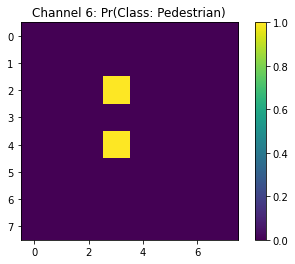

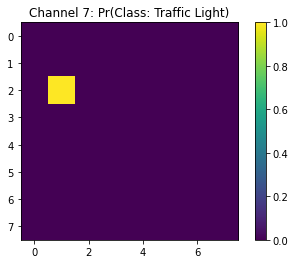

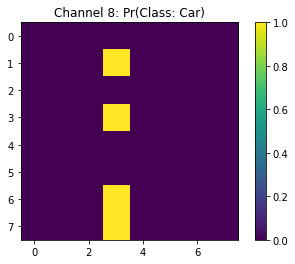

In [117]:
# # Visualize the 8x8x8 representation.
# import seaborn as sns

plt.imshow(label_processed[0, 0, :, :])
plt.colorbar()
plt.title("Channel 1: Pr(Objectness)")
plt.show()

plt.imshow(label_processed[0, 1, :, :])
plt.colorbar()
plt.title("Channel 2: X center")
plt.show()

plt.imshow(label_processed[0, 2, :, :])
plt.colorbar()
plt.title("Channel 3: Y center")
plt.show()

plt.imshow(label_processed[0, 3, :, :])
plt.colorbar()
plt.title("Channel 4: Width")
plt.show()

plt.imshow(label_processed[0, 4, :, :])
plt.colorbar()
plt.title("Channel 5: Height")
plt.show()

plt.imshow(label_processed[0, 5, :, :])
plt.colorbar()
plt.title("Channel 6: Pr(Class: Pedestrian)")
plt.show()

plt.imshow(label_processed[0, 6, :, :])
plt.colorbar()
plt.title("Channel 7: Pr(Class: Traffic Light)")
plt.show()

plt.imshow(label_processed[0, 7, :, :])
plt.colorbar()
plt.title("Channel 8: Pr(Class: Car)")
plt.show()



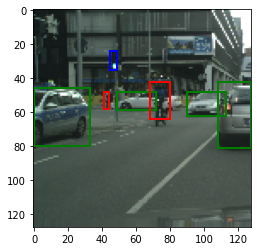

In [118]:
# Convert back to the original representation (test cases below should pass).
label_reconstructed = reconstruct_raw_labels(label_processed, img_dim=128)

fig = plt.imshow(chosen_image)
for label in label_reconstructed:
  if label[0] == 0:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'red'))
  if label[0] == 1:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'blue'))
  if label[0] == 2:
    fig.axes.add_patch(bbox_to_rect(label[1:], 'green'))

2. Implement the loss function. (3%)

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

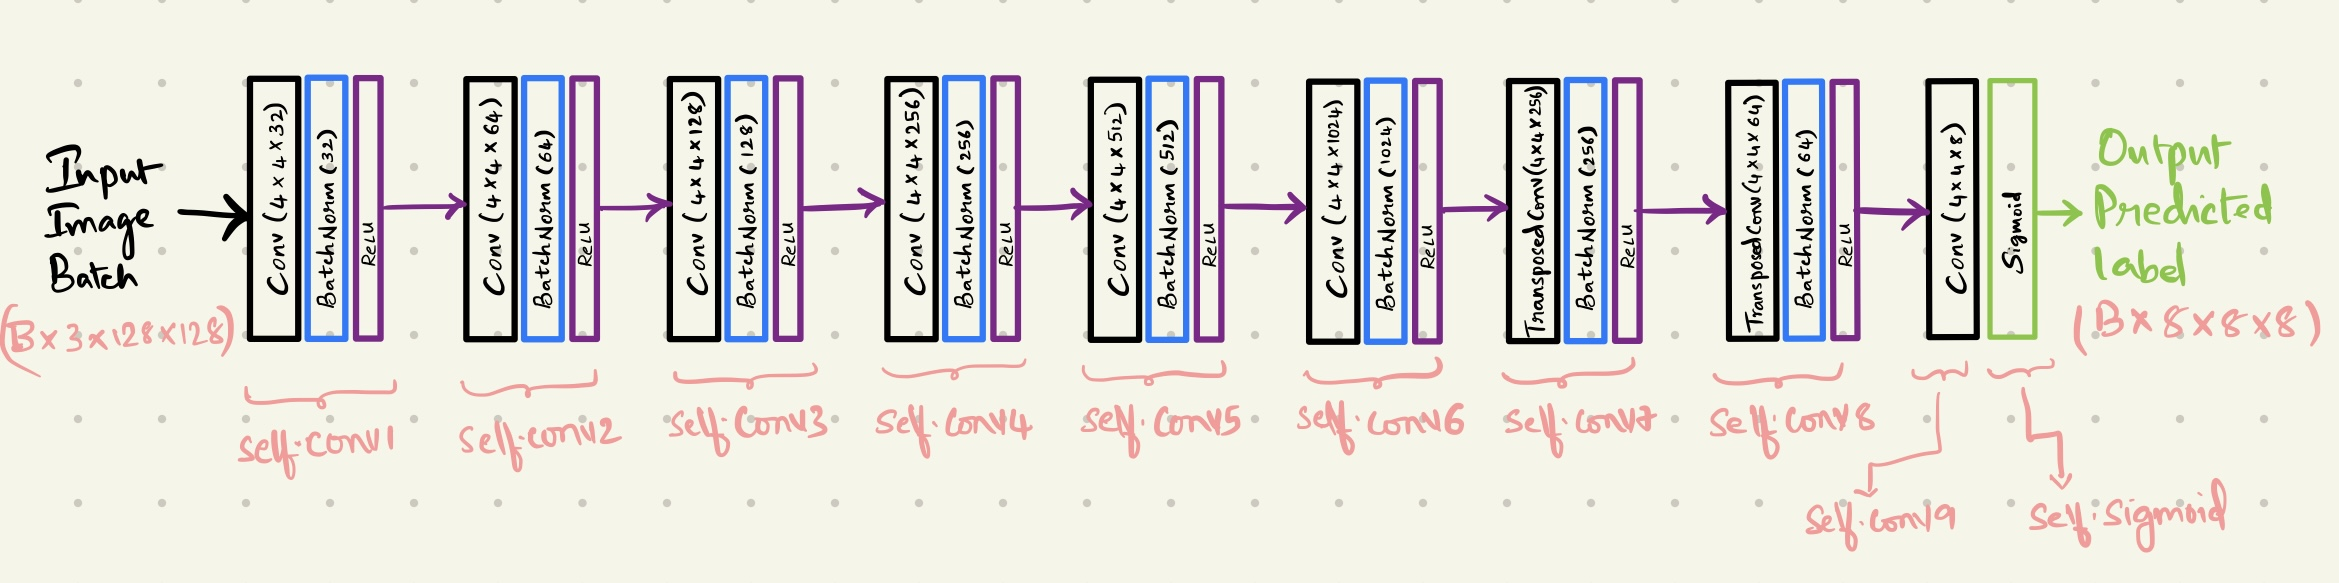

### `As all the values of train set are in the range of [0,1] the predicted values were also having few negative values due to the errors in the model estimates so we added a sigmoid layer at the end to make sure that our output of the model also lies between [0,1]. Pink text in the figure corresponds to the variables (nn.Sequential blocks) in our code.`

---



4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [119]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class YoloDataset(Dataset):

    def __init__(self, data, labels, transform=None):
    
        self.data = data
        self.labels = torch.tensor(labels)
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):

        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [120]:
from pytorch_lightning.core.datamodule import LightningDataModule
from torch.utils.data import random_split, DataLoader 

class YoloDataModule(LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()

        self.dataset = dataset
        self.batch_size = batch_size

        return

    def setup(self, stage=None):
        val_split = int(0.05 * len(self.dataset))
        test_split = int(0.05 * len(self.dataset))  # 5% of data to be used as validation set
        self.train_data, self.valid_data, self.test_data = random_split(self.dataset, [len(self.dataset)-val_split-test_split, val_split, test_split])

        return
        

    def train_dataloader(self):
        
        # Generating train_dataloader
        return DataLoader(self.train_data, batch_size = self.batch_size)
  
    def val_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.valid_data, batch_size = self.batch_size)
    
    def predict_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.dataset, batch_size = 1)


In [121]:
# Setup your training

checkpoint_callback = pl_callbacks.ModelCheckpoint()
tb_logger = pl_loggers.TensorBoardLogger("logs/")

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

processed_labels = process_labels(raw_labels)

YoloData = YoloDataset(images, processed_labels, transform)
YoloDataLoader = YoloDataModule(YoloData, batch_size=32)

In [122]:
model = YOLO.load_from_url()

In [154]:
# Train your model
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
model = YOLO()
# model = YOLO.load_from_checkpoint('/content/gdrive/MyDrive/Project2_YOLO/lightning_logs/version_80/checkpoints/epoch=59-step=8340.ckpt')
model = YOLO.load_from_url()
trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=0.5, max_epochs = 60, auto_lr_find=True)

# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/
# # trainer.fit(model, train_loader, val_loader)
# trainer.fit(model, YoloDataLoader)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Text(0.5, 1.0, 'Val Loss vs Epoch')

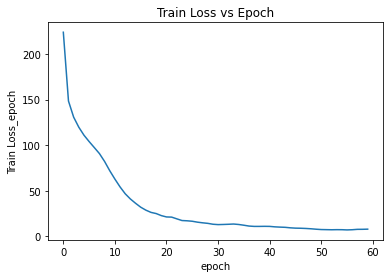

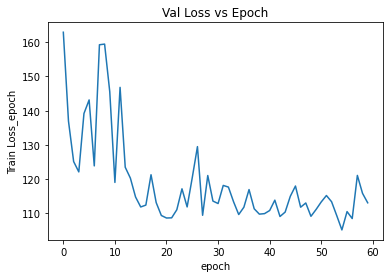

In [124]:
# Plot the results
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = "lightning_logs/version_86"
y_key = "Train Loss_epoch"

y_key_val = 'Val Loss_epoch'

event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

steps_train = {x.step for x in event_accumulator.Scalars(y_key)}
x_train = list(range(len(steps_train)))
# print(x)
y_train = [x.value for x in event_accumulator.Scalars(y_key) if x.step in steps_train]

steps_val = {x.step for x in event_accumulator.Scalars(y_key_val)}
x_val = list(range(len(steps_val)))
# print(x)
y_val = [x.value for x in event_accumulator.Scalars(y_key_val) if x.step in steps_val]
# for x in event_accumulator.Scalars(y_key):
#   if x.step in steps:
#     print(x.step)
# print(y)
fig, ax1 = plt.subplots()
ax1.plot(x_train, y_train)
ax1.set_xlabel("epoch")
ax1.set_ylabel(y_key)
ax1.set_title('Train Loss vs Epoch')

fig, ax2 = plt.subplots()
ax2.plot(x_val, y_val)
ax2.set_xlabel("epoch")
ax2.set_ylabel(y_key)
ax2.set_title('Val Loss vs Epoch')
# fig.savefig("plot.png")

#### `Looks like our Model is overfitting to the training data we will try to make changes to our model accordingly to account for this in 2b. Also, since the size of the entire dataset itself is low, we had to consider only 5% for validation data which is further low. This small validation dataset doesnt seem to capture the performance of the model very well and hence the validation loss could be unstable though the training loss curve is decreasing as expected. `

In [126]:
test = trainer.predict(model, YoloDataLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 139it [00:00, ?it/s]

In [141]:
def low_confidence_suppression(label):
    lab =[]
    # print('before', labels.shape)
    # for i, label in enumerate(labels):
    # label = label.unsqueeze(0)
  
    mask = label[:,0,:,:]>0.6
    label = label*mask
      # labels[i] = label.squeeze(0)
    # print(labels.shape)
    return label

def non_max_suppression(label):
    
    lab = []
    
    # for i, label in enumerate(labels):
    thresh_iou = 0.5
    # label = label
    # we extract coordinates for every 
    # prediction box present in P
    x1 = (label[:, 1, :, :] - 8*label[:, 3, :, :] / 2).squeeze(0).reshape(-1)
    y1 = (label[:, 2, :, :] - 8*label[:, 4, :, :] / 2).squeeze(0).reshape(-1)
    x2 = (label[:, 1, :, :] + 8*label[:, 3, :, :] / 2).squeeze(0).reshape(-1)
    y2 = (label[:, 2, :, :] + 8*label[:, 4, :, :] / 2).squeeze(0).reshape(-1)
    # x1 = label[:, 1, :, :].squeeze(0).reshape(-1)
    # y1 = label[:, 2, :, :].squeeze(0).reshape(-1)
    # x2 = label[:, 3, :, :].squeeze(0).reshape(-1)
    # y2 = label[:, 4, :, :].squeeze(0).reshape(-1)
    

    # we extract the confidence scores as well
    scores = label[:, 0, :, :].squeeze(0).reshape(-1)

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
    
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
    # print(order.shape)
    # print(order)

    # initialise an empty list for 
    # filtered prediction boxes
    keep = np.zeros(scores.shape)
    

    while len(order) > 0:
        
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        # print(label)
        # print(idx)
        keep[idx] += 1

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = (xx2 - xx1)
        h = (yy2 - yy1)
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        # print(w, h)
        for i, num in enumerate(w):
          if num<0:
            w[i]=0.0
        for i, num in enumerate(h):
          if num<0:
            h[i]=0.0


        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    # print(keep)
    
    label = label*keep.reshape(8,8)
      # print(label.shape)
      # print(label.squeeze(0).shape)
      
      # labels[i] = label.squeeze()
    # print(labels.shape)
    return label

In [143]:
test_labels = []
original_labels = []
for i, input in enumerate(YoloDataLoader.predict_dataloader()):
  # if i == image_num:
  image_num = i
  low_label = low_confidence_suppression(test[image_num])
  # print(low_label.shape)
  test_label = non_max_suppression(low_label)
  test_labels.append(test_label)
  _, original_label = input
  original_labels.append(original_label)

In [ ]:
# model.inference(images, raw_labels)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

array([[array([], dtype=float64)],
       [array([[  2.        ,   0.8469618 ,   1.25891876,  34.95580196,
                 58.42502594, 106.22954464],
               [  2.        ,   0.84895152,  42.07797968,  40.92256641,
                 87.88999522,  73.30064106]])                          ],
       [array([[ 2.        ,  0.78597564, -0.76116323, 49.17041969, 11.25971556,
                64.51942635]])                                                  ],
       ...,
       [array([], dtype=float64)],
       [array([[ 2.        ,  0.88533866,  0.3315506 , 49.00816607, 27.08308601,
                84.82023883],
               [ 2.        ,  0.894952  ,  3.6047368 , 46.5928688 , 62.0788579 ,
                78.48820114],
               [ 2.        ,  0.80458313, 71.6502459 , 49.67609024, 93.2764895 ,
                66.7044754 ]])                                                  ],
       [array([[  2.        ,   0.77742267,  77.78296375,  50.97965813,
                 98.57235241,  67

5. Show a plot of the mean Average Precision over training for your model. (10%)

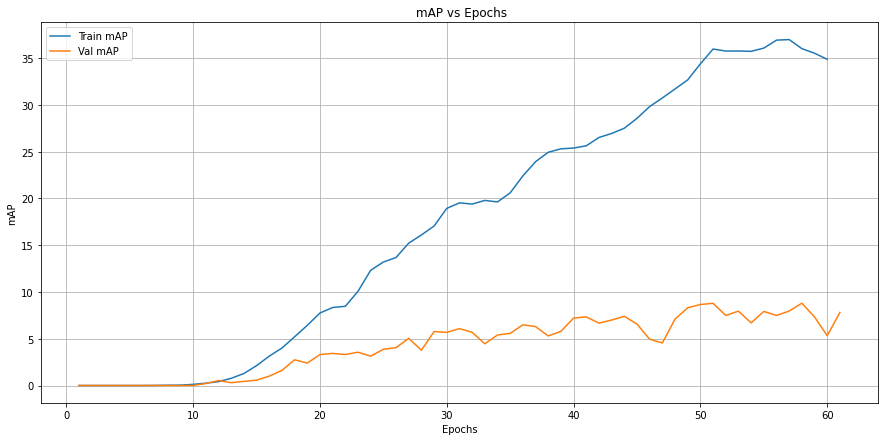

In [125]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(len(train_mAP))+1, np.array(train_mAP), label='Train mAP')
plt.plot(np.arange(len(val_mAP))+1, np.array(val_mAP), label='Val mAP')
plt.title(" mAP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.legend()
plt.grid('on')
plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

##Commenting the code as we get no module name cv2 error.

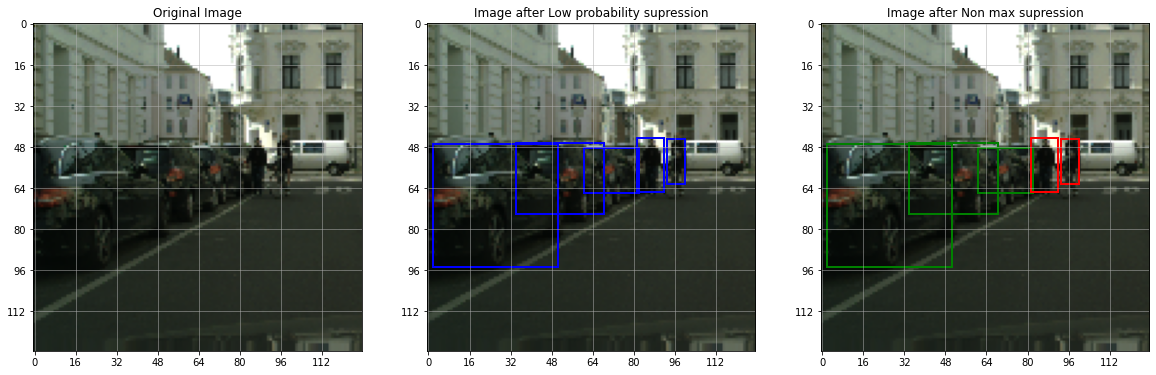

In [144]:
# # # Convert back to the original representation (test cases below should pass).
# import cv2

# # im, original_label = next(iter(YoloDataLoader.predict_dataloader()))
# for i, input in enumerate(YoloDataLoader.predict_dataloader()):
#   # if i == image_num:
#   image_num = 6
#   low_label = low_confidence_suppression(test[image_num])
#   test_label = non_max_suppression(low_label)

#   low_label_reconstructed = (reconstruct_raw_labels(low_label, img_dim=128))

#   label_reconstructed = reconstruct_raw_labels(test_label, img_dim=128)
#   im, original_label = input
#   # label_reconstructed = reconstruct_raw_labels(test[image_num], img_dim=128)
#   # print(label_reconstructed.shape)
#   # print(original_label)
#   # print(test[image_num])
#   norm_image = cv2.normalize(im.squeeze(0).detach().numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#   norm_image = norm_image.astype(np.uint8)

#   # print(np.max(norm_image))
#   # print(np.min(norm_image))
#   # print(norm_image)
#   if i==image_num:
#     chosen_image = np.einsum('kij -> ijk', norm_image)
#     f, ax = plt.subplots(1,3, figsize=(20, 8))
#     fig2 = ax[0].imshow(chosen_image)
#     fig1 = ax[1].imshow(chosen_image)
#     fig = ax[2].imshow(chosen_image)
#     # plt.show()

#     if low_label_reconstructed.shape==(5,):
#       low_label_reconstructed = [low_label_reconstructed]
#     for label in low_label_reconstructed:
#       fig1.axes.add_patch(bbox_to_rect(label[1:], 'blue'))

#     if label_reconstructed.shape==(5,):
#       label_reconstructed = [label_reconstructed]
#     for label in label_reconstructed:
#       if label[0] == 0:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'red'))
#       if label[0] == 1:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'blue'))
#       if label[0] == 2:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'green'))
#     ax[0].set_xticks(np.arange(0, 128, 16))
#     ax[0].set_yticks(np.arange(0, 128, 16))
#     ax[0].set_title('Original Image')
#     ax[0].grid(linewidth=0.5)
#     ax[1].set_xticks(np.arange(0, 128, 16))
#     ax[1].set_yticks(np.arange(0, 128, 16))
#     ax[1].set_title('Image after Low probability supression',)
#     ax[1].grid(linewidth=0.5)
#     ax[2].set_xticks(np.arange(0, 128, 16))
#     ax[2].set_yticks(np.arange(0, 128, 16))
#     ax[2].set_title('Image after Non max supression')
#     ax[2].grid(linewidth=0.5)
#     plt.show()
#     break

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

##Commenting the code as we get no module name cv2 error.

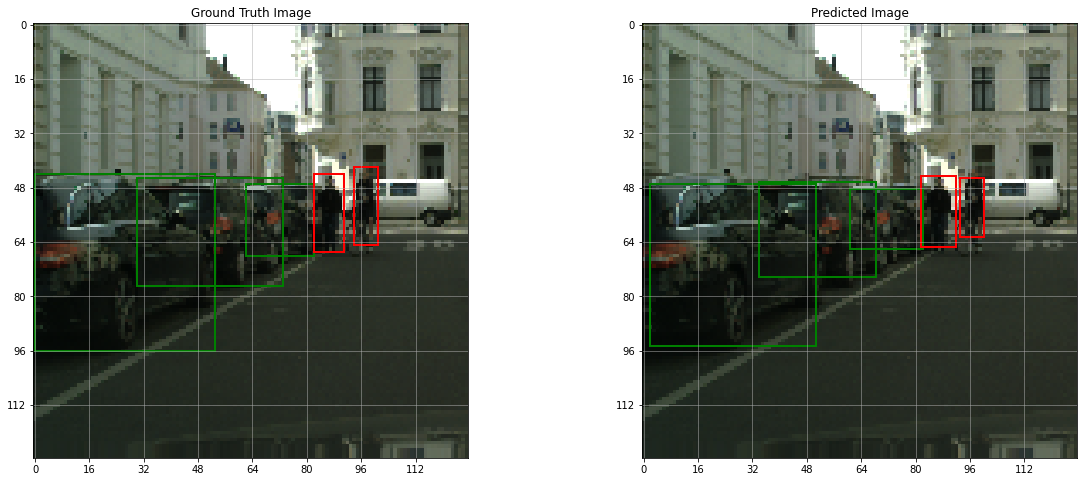

In [145]:
# # # Convert back to the original representation (test cases below should pass).
# import cv2

# # im, original_label = next(iter(YoloDataLoader.predict_dataloader()))
# for i, input in enumerate(YoloDataLoader.predict_dataloader()):
#   # if i == image_num:
#   image_num = 6
#   low_label = low_confidence_suppression(test[image_num])
#   test_label = non_max_suppression(low_label)

#   low_label_reconstructed = (reconstruct_raw_labels(low_label, img_dim=128))

#   label_reconstructed = reconstruct_raw_labels(test_label, img_dim=128)
#   im, original_label = input
#   original_label_reconstructed = reconstruct_raw_labels(original_label, img_dim=128)
#   # label_reconstructed = reconstruct_raw_labels(test[image_num], img_dim=128)
#   # print(label_reconstructed.shape)
#   # print(original_label)
#   # print(test[image_num])
#   norm_image = cv2.normalize(im.squeeze(0).detach().numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#   norm_image = norm_image.astype(np.uint8)

#   # print(np.max(norm_image))
#   # print(np.min(norm_image))
#   # print(norm_image)
#   if i==image_num:
#     chosen_image = np.einsum('kij -> ijk', norm_image)
#     f, ax = plt.subplots(1,2, figsize=(20, 8))
#     fig2 = ax[0].imshow(chosen_image)
#     # fig1 = ax[1].imshow(chosen_image)
#     fig = ax[1].imshow(chosen_image)
#     # plt.show()
#     for label in original_label_reconstructed:
#       if label[0] == 0:
#         fig2.axes.add_patch(bbox_to_rect(label[1:], 'red'))
#       if label[0] == 1:
#         fig2.axes.add_patch(bbox_to_rect(label[1:], 'blue'))
#       if label[0] == 2:
#         fig2.axes.add_patch(bbox_to_rect(label[1:], 'green'))

#     # if low_label_reconstructed.shape==(5,):
#     #   low_label_reconstructed = [low_label_reconstructed]
#     # for label in low_label_reconstructed:
#     #   fig1.axes.add_patch(bbox_to_rect(label[1:], 'blue'))

#     if label_reconstructed.shape==(5,):
#       label_reconstructed = [label_reconstructed]
#     for label in label_reconstructed:
#       if label[0] == 0:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'red'))
#       if label[0] == 1:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'blue'))
#       if label[0] == 2:
#         fig.axes.add_patch(bbox_to_rect(label[1:], 'green'))
#     ax[0].set_xticks(np.arange(0, 128, 16))
#     ax[0].set_yticks(np.arange(0, 128, 16))
#     ax[0].set_title('Ground Truth Image')
#     ax[0].grid(linewidth=0.5)
#     # ax[1].set_xticks(np.arange(0, 128, 16))
#     # ax[1].set_yticks(np.arange(0, 128, 16))
#     # ax[1].set_title('Image after Low probability supression',)
#     # ax[1].grid(linewidth=0.5)
#     ax[1].set_xticks(np.arange(0, 128, 16))
#     ax[1].set_yticks(np.arange(0, 128, 16))
#     ax[1].set_title('Predicted Image')
#     ax[1].grid(linewidth=0.5)
#     plt.show()
#     break

In [146]:
# P-R curve for each class
def average_precision_plot(predictions, targets, target_class):
    recall, precision = precision_recall_curve(predictions, targets, target_class)
    precision_interpolated = np.maximum.accumulate(precision[::-1])[::-1]
    # average_precision = auc(recall, precision)
    average_precision = 0
    n = len(precision)
    for i in range(1, n):
        average_precision += precision_interpolated[i] * (recall[i] - recall[i - 1])
    
    # plt.figure(figsize=(8,5))
    plt.plot(recall, precision)
    plt.plot(recall, precision_interpolated)
    plt.title(f"Class {target_class}, AP:{round(average_precision*100, 2)}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid('on')
    plt.show()

    return average_precision

def mean_average_precision_plot(predictions, targets):
    avg_precision = []
    predictions_list =[]
    targets_list =[]
    # print(predictions[0])
    for i in range(len(predictions)):
      predictions_list.append(reconstruct_raw_labels_map_(predictions[i]))
      targets_list.append(reconstruct_raw_labels_map_(targets[i]))
    # print(predictions_list)
    
    
    predictions_dict_list= []
    targets_dict_list = []
    for i,prediction in enumerate(predictions_list):
      predictions_dict = defaultdict(list)
      for bboxs in prediction:
        for bbox in bboxs:
          # print(bbox)
          if bbox[0] == 0:
            predictions_dict['0'].append(bbox[1:])
          if bbox[0] ==1:
            predictions_dict['1'].append(bbox[1:])
          if bbox[0] == 2:
            predictions_dict['2'].append(bbox[1:])
      predictions_dict_list.append(predictions_dict)
      
    for i,target in enumerate(targets_list):
      targets_dict = defaultdict(list)
      for bboxs in target:
        for bbox in bboxs:
          if bbox[0] == 0:
            targets_dict['0'].append(bbox[1:])
          if bbox[0] ==1:
            targets_dict['1'].append(bbox[1:])
          if bbox[0] == 2:
            targets_dict['2'].append(bbox[1:])
      targets_dict_list.append(targets_dict)
    # print('nkh',np.array(predictions_dict_list[0]['0']))
    for cls in ['0', '1', '2']:
      # if len(np.array(predictions_dict[cls])) == 0:

      #   continue
      avg_precision_class = average_precision_plot(predictions_dict_list, targets_dict_list, cls)
      avg_precision.append(avg_precision_class)
    mean_average_precision = np.mean(avg_precision)
    print('mAP for inference',round(mean_average_precision*100,2))
    return round(mean_average_precision*100,2)
    

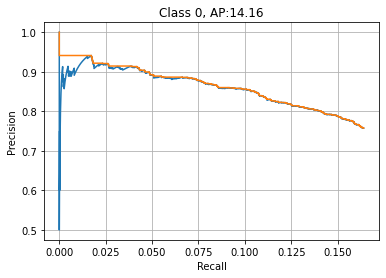

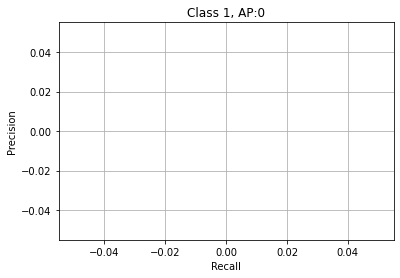

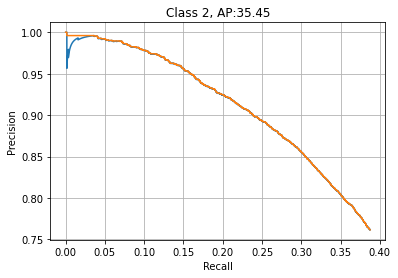

mAP for inference 16.54


16.54

In [147]:
mean_average_precision_plot(test_labels, original_labels)

## mAP for inference stage we have is 16.54

###Code for submission

In [150]:
def reconstruct_raw_labels_map(labels, img_dim=128):
    raw_labels = []
    for label in labels:
      raw_label = []
      # print("label.shape: ", label.shape)
      for i in range(label.shape[1]):
        for j in range(label.shape[2]):
          if label[0][i][j]:
            # print(label[5:8, i, j])
            # print(np.argmax(label[5:8, i, j]))
            # box_class = np.argmax(label[5:8, i, j]).item()
            box_class = np.argmax(label[5:8, i, j])
            # 1 - x_centre, 2 - y_centre, 3 - width, 4 - height
            left_corner = [(label[1][i][j]*16+i*16) - (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) - (label[4][i][j]*128 / 2)]
            right_corner = [(label[1][i][j]*16+i*16) + (label[3][i][j]*128 / 2), (label[2][i][j]*16+j*16) + (label[4][i][j]*128 / 2)]
            raw_label_box = [box_class, label[0][i][j]] + left_corner + right_corner

            raw_label.append(np.array(raw_label_box))
      
      # raw_labels.append(np.array(raw_label))

    return np.array(raw_label)

In [151]:
def npz_file(predictions, out_filepath):
    # preds=[]
      # adding None for training data samples
    
    preds = [reconstruct_raw_labels_map(prediction) for prediction in predictions]


    # create output

    for i,p in enumerate(preds):
      if len(list(p))==0:
        preds[i]=None
        
    
 
    np.savez(out_filepath, np.array(preds, dtype=object))

    return np.array(preds, dtype=object)


In [152]:
preds = npz_file(test_labels, 'YOLO_results.npz')

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

**Issues and Challenges Faced:**



1.   The first issue we faced was in the network architecture itself. We first 
implemented the network given the paper and were trying to figure out the dimensions of convolutions before the fully connected layer. Later, we saw that a simpler architecture is given in the colab notebook. We then replaced this with the new implementation. 
2.   The second issue we faced was - not updating the scale of x, y centers and width, height to make them relative to the grid cell. We were using the original x, y, w, h values. And this was affecting the training performance as well. 

3. The loss curves were unstable when we trained this network. Then we had to look at various factors that could affect the training of this model. Our initial doubts were on network architecture layers and the loff function computation. We realized that - as all the values of train set are in the range of [0,1], the predicted values were also having few negative values due to the errors in the model estimates. So we added a sigmoid layer at the end of the network architecture to make sure that our output of the model also lies between [0,1]. This constraint helped in better approximation of all channels in the final output. We also trained the network with sigmoid on the first five channels and a softmax layer on the last three channels since last three channels correspond to the one-hot encoding of the output class. Anyway, the initial approach of a sigmoid on all layers performed better. 

4. We also realized that the training was unstable due to the loss value computation itself. Our initial implementation of $C$ was the same as target objectness (actual probability of a box containing an object) and $\hat{C}$ was the product of output objectness (predicted probability of a box containing an object) and IoU between actual box and predicted bounding box. But the correct implementation of $C$ is IoU and  $\hat{C}$ is just output objectness. The learning improved after making these two changes.

5. Another issue we faced was during the IoU calculation. Since, we initially drafted the whole code without changing the frame of reference for x, y, w, h we were using the values as it is in IoU computation. After making x, y, w, h relative to the grid cells, we had to debug for a while and later we realized that the IoU computation was going wrong. So, we need to update to account for the global frame of reference and get the x,y and w,h to a single global frame of reference. 

**Suggestions for improvements:**
 

1.   We could account for multiple objects in a particular grid cell since that’s a possibility too. So, we need to have more than one anchor box per grid cell. 
2.   We used 9900 images for training, validation and prediction. A larger dataset will definitely improve the performance to an extent. 
3. We also observed some class imbalance when we were monitoring the prediction results. We saw the traffic lights are rarely present in the data which affected it’s prediction performance during testing as well. More data with traffic lights will aid the network predict traffic lights better. 

4. Before the actual object detection layers, we can add pretrained network layers like ResNet which will help the model detect and learn features in the input image which can be used in the following layers. This is a kind of transfer learning. 

5. Also, the resolution of each image was 128x128. So, we can add a pretrained super-resolution network in the beginning of the architecture which will help it super resolve the image so that the details get clearer along with learning the features in the input image (since detecting the features is included super resolution process). Or We can use a good super-resolution network like SRGAN, ESRGAN, etc to create corresponding higher resolution images for all the input images and then use this directly as the training data. For this, we’ll have to adjust the target boxes' dimensions accordingly.  

6. There are multiple hyperparameters and various attributes in the loss function that could've been improved. Hyperparameter tuning requires a lot of time and compute power. We also have other hyperparameters in low confidence and non-maximum suppression as well that can be tuned. One thing in loss function that can be improved is - instead of mean squared error in the last summation we can use log likelihood.  


## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf cis680_hw2.ipynb